In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from PIL import Image
from scipy.stats import skew
from matplotlib.transforms import Bbox
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv(
    "/Users/berkan_oztas/TM-Project/data/raw/SAML-D.csv"
)
df.head()


,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type
0,10:35:19,2022-10-07,8724731955,2769355426,1459.15,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits
1,10:35:20,2022-10-07,1491989064,8401255335,6019.64,UK pounds,Dirham,UK,UAE,Cross-border,0,Normal_Fan_Out
2,10:35:20,2022-10-07,287305149,4404767002,14328.44,UK pounds,UK pounds,UK,UK,Cheque,0,Normal_Small_Fan_Out
3,10:35:21,2022-10-07,5376652437,9600420220,11895.00,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Fan_In
4,10:35:21,2022-10-07,9614186178,3803336972,115.25,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9504852 entries, 0 to 9504851
Data columns (total 12 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Time                    object 
 1   Date                    object 
 2   Sender_account          int64  
 3   Receiver_account        int64  
 4   Amount                  float64
 5   Payment_currency        object 
 6   Received_currency       object 
 7   Sender_bank_location    object 
 8   Receiver_bank_location  object 
 9   Payment_type            object 
 10  Is_laundering           int64  
 11  Laundering_type         object 
dtypes: float64(1), int64(3), object(8)
memory usage: 870.2+ MB


In [4]:
df.describe()

,Sender_account,Receiver_account,Amount,Is_laundering
count,9.504852e+06,9.504852e+06,9.504852e+06,9.504852e+06
mean,5.006619e+09,5.006006e+09,8.762968e+03,1.038733e-03
std,2.885814e+09,2.884763e+09,2.561495e+04,3.221263e-02
min,9.018000e+03,9.018000e+03,3.730000e+00,0.000000e+00
25%,2.513133e+09,2.513219e+09,2.143688e+03,0.000000e+00
50%,5.001017e+09,5.002572e+09,6.113720e+03,0.000000e+00
75%,7.505051e+09,7.502397e+09,1.045846e+04,0.000000e+00
max,9.999987e+09,9.999971e+09,1.261850e+07,1.000000e+00


In [5]:
# number of transactions per payment type
transactions_per_payment_type = df['Payment_type'].value_counts()

# number of laundering transactions per payment type
laundering_transactions_per_payment_type = df[df['Is_laundering'] == 1].groupby('Payment_type').size()

transactions_per_payment_type, laundering_transactions_per_payment_type

(Payment_type
 Credit card        2012909
 Debit card         2012103
 Cheque             2011419
 ACH                2008807
 Cross-border        933931
 Cash Withdrawal     300477
 Cash Deposit        225206
 Name: count, dtype: int64,
 Payment_type
 ACH                1159
 Cash Deposit       1405
 Cash Withdrawal    1334
 Cheque             1087
 Credit card        1136
 Cross-border       2628
 Debit card         1124
 dtype: int64)

In [6]:
# Analyze transactions per payment type
transactions_per_payment_type = df['Payment_type'].value_counts()
laundering_transactions_per_payment_type = df[df['Is_laundering'] == 1].groupby('Payment_type').size()

# Compare transaction statistics for laundering and normal transactions
laundering_stats = df[df['Is_laundering'] == 1]['Amount'].agg(['max', 'mean', 'min'])
normal_stats = df[df['Is_laundering'] == 0]['Amount'].agg(['max', 'mean', 'min'])

print("Laundering Transactions Stats:\n", laundering_stats)
print("\nNormal Transactions Stats:\n", normal_stats)

Laundering Transactions Stats:
 max     1.261850e+07
mean    4.058767e+04
min     1.582000e+01
Name: Amount, dtype: float64

Normal Transactions Stats:
 max     999962.190000
mean      8729.875874
min          3.730000
Name: Amount, dtype: float64


(np.float64(-1.0999999999832932),
 np.float64(1.0999999999992045),
 np.float64(-1.0999999999442114),
 np.float64(1.0999999999952341))

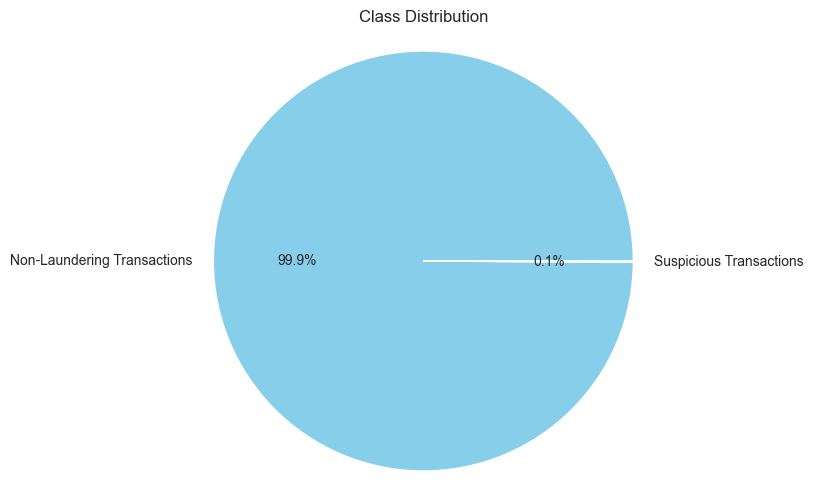

In [18]:
# Visualize class distribution (laundering vs non-laundering transactions)
class_distribution = df['Is_laundering'].value_counts()
plt.figure(figsize=(10, 6))
plt.pie(class_distribution, labels=['Non-Laundering Transactions', 'Suspicious Transactions'], autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
plt.title('Class Distribution')
plt.axis('equal')
plt.savefig('/Users/berkan_oztas/TM-Project/Report/Figures/class_distribution.png', dpi=300, bbox_inches='tight')
plt.close()

In [8]:
# Analyze monthly transaction patterns
df['Date'] = pd.to_datetime(df['Date'])
monthly_transactions = df.groupby(df['Date'].dt.to_period('D')).size()
average_monthly_transactions = monthly_transactions.mean()

plt.figure(figsize=(10, 6))
monthly_transactions.plot(kind='line')
plt.axhline(y=average_monthly_transactions, color='r', linestyle='--', label=f'Average Transactions ({average_monthly_transactions:.2f})')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.title('Average Number of Transactions Per Month')
plt.legend()
plt.grid(True)
plt.savefig('/Users/berkan_oztas/TM-Project/Report/Figures/monthly_transactions.png', dpi=300, bbox_inches='tight')
plt.close()

In [9]:
# Visualize suspicious transaction amounts
laundering_data = df[df['Is_laundering'] == 1]
non_laundering_data = df[df['Is_laundering'] == 0]

plt.figure(figsize=(10, 6))
plt.scatter(laundering_data.index, laundering_data['Amount'], color='red', label='Laundering', alpha=0.7)
plt.title('Suspicious Transaction Amounts')
plt.xlabel('Transaction Index')
plt.ylabel('Transaction Amount')
plt.legend()
plt.grid(True)
plt.savefig('/Users/berkan_oztas/TM-Project/Report/Figures/suspicious_transaction_amounts.png', dpi=300, bbox_inches='tight')
plt.close()

In [10]:
# Analyze distribution of laundering alerts per account
laundering_df = df[df['Is_laundering'] == 1]
account_alert_counts = laundering_df.groupby('Sender_account').size()
alert_distribution = account_alert_counts.value_counts().sort_index()

# Visualize alert distribution using a split bar chart
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))
fig.subplots_adjust(hspace=0.1)
alert_distribution.plot(kind='bar', ax=ax1)
alert_distribution.plot(kind='bar', ax=ax2)
fig.suptitle('Distribution of Number of Laundering Alerts Per Account')
ax1.set_ylim(3500, alert_distribution.max()+50)
ax2.set_ylim(0, 350)
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)
ax2.xaxis.tick_bottom()
d = .015  # diagonal lines size
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)
ax2.set_ylabel('Number of Accounts (0 to 350)')
ax1.set_ylabel('Number of Accounts (3500 and above)')
ax2.set_xlabel('Number of Alerts')
plt.savefig('/Users/berkan_oztas/TM-Project/Report/Figures/laundering_alerts_distribution.png', dpi=300, bbox_inches='tight')
plt.close()

In [11]:
# Analyze and transform skewed data (transaction amounts)
skewed_data = df['Amount']
original_skewness = skew(skewed_data)
print(f"Original Skewness: {original_skewness}")
log_transformed_data = np.log1p(skewed_data)
transformed_skewness = skew(log_transformed_data)
print(f"Log-Transformed Skewness: {transformed_skewness}")

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
sns.histplot(skewed_data, bins=500, kde=True, ax=ax[0])
ax[0].set_title('Original Skewed Distribution')
ax[0].set_xlabel('Amount')
ax[0].set_ylabel('Frequency')
sns.histplot(log_transformed_data, bins=50, kde=True, ax=ax[1])
ax[1].set_title('Log-Transformed Distribution')
ax[1].set_xlabel('Log(Amount)')
ax[1].set_ylabel('Frequency')
plt.tight_layout()
plt.savefig('/Users/berkan_oztas/TM-Project/Report/Figures/skewed_data_transformation.png', dpi=300, bbox_inches='tight')
plt.close()


Original Skewness: 102.16408577285024
Log-Transformed Skewness: -1.0103052224946008


In [12]:
# Analyze payment types, total amounts, and laundering counts
total_amount_pivot = pd.pivot_table(df, index=["Payment_type"], values='Amount', aggfunc=np.sum)
laundering_count_pivot = df[df['Is_laundering'] == 1].groupby('Payment_type').size().to_frame('Laundering_Count')
normal_count_pivot = df[df['Is_laundering'] == 0].groupby('Payment_type').size().to_frame('Normal_Count')
combined_pivot = total_amount_pivot.join([laundering_count_pivot, normal_count_pivot], how='outer').fillna(0)

cm = sns.light_palette("blue", as_cmap=True)
styled_combined_pivot = combined_pivot.style.background_gradient(cmap=cm)
styled_combined_pivot

/var/folders/fr/36b9tdx11176pcsn2bjv805h0000gn/T/ipykernel_86316/2808873988.py:2: FutureWarning: The provided callable <function sum at 0x1092811c0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  total_amount_pivot = pd.pivot_table(df, index=["Payment_type"], values='Amount', aggfunc=np.sum)


,Amount,Laundering_Count,Normal_Count
Payment_type,,,
ACH,18272052011.854218,1159,2007648
Cash Deposit,485809045.640000,1405,223801
Cash Withdrawal,46118125.580000,1334,299143
Cheque,18328875956.816402,1087,2010332
Credit card,18308924931.183823,1136,2011773
Cross-border,9476591292.695444,2628,931303
Debit card,18372338763.838520,1124,2010979


In [13]:
# Visualize monthly alerts by payment type
grouped_data = df.groupby(['Date', 'Payment_type']).agg({'Is_laundering': 'sum'}).reset_index()
grouped_data['Month_Year'] = grouped_data['Date'].dt.to_period('M')
monthly_alerts = grouped_data.groupby(['Month_Year', 'Payment_type']).agg({'Is_laundering': 'sum'}).reset_index()
pivot_data = monthly_alerts.pivot(index='Month_Year', columns='Payment_type', values='Is_laundering')

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(12, 7))
pivot_data.plot(kind='bar', ax=ax, stacked=True, colormap='viridis')
plt.title('Number of Alerts Per Month Split by Payment Type', fontsize=14)
plt.xlabel('Month-Year', fontsize=12)
plt.ylabel('Number of Alerts', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Payment Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('/Users/berkan_oztas/TM-Project/Report/Figures/monthly_alerts_by_payment_type.png', dpi=300, bbox_inches='tight')
plt.close()

In [14]:
# Analyze alerts by sender bank location
alerts_per_location = df.groupby('Sender_bank_location')['Is_laundering'].sum().reset_index()

# Visualize alerts by sender bank location using a split bar chart
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
fig.subplots_adjust(wspace=0.1)
ax1.barh(alerts_per_location['Sender_bank_location'], alerts_per_location['Is_laundering'], color='skyblue')
ax2.barh(alerts_per_location['Sender_bank_location'], alerts_per_location['Is_laundering'], color='skyblue')
ax1.set_xlim(0, 100)  # Set the left subplot values
ax2.set_xlim(8000, max(alerts_per_location['Is_laundering']) + 100)  # Set the right subplot values
fig.suptitle('Number of Alerts per Sender Bank Location')
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.yaxis.tick_left()
ax2.yaxis.tick_right()
ax2.set_yticks([])
d = .015  # Size of diagonal lines
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)
kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (-d, +d), **kwargs)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
ax1.set_xlabel('Number of Alerts (0 to 100)')
ax2.set_xlabel('Number of Alerts (8000 and above)')
ax1.set_ylabel('Sender Bank Location')
ax1.set_yticks(range(len(alerts_per_location['Sender_bank_location'])))
ax1.set_yticklabels(alerts_per_location['Sender_bank_location'])
plt.savefig('/Users/berkan_oztas/TM-Project/Report/Figures/alerts_by_sender_bank_location.png', dpi=300, bbox_inches='tight')
plt.close()

In [15]:
# Analyze alerts by receiver bank location
alerts_per_location = df.groupby('Receiver_bank_location')['Is_laundering'].sum().reset_index()

# Visualize alerts by receiver bank location using a split bar chart
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
fig.subplots_adjust(wspace=0.1)  # Adjust the spacing between subplots
ax1.barh(alerts_per_location['Receiver_bank_location'], alerts_per_location['Is_laundering'], color='skyblue')
ax2.barh(alerts_per_location['Receiver_bank_location'], alerts_per_location['Is_laundering'], color='skyblue')
ax1.set_xlim(0, 300)  # Set the left subplot values
ax2.set_xlim(6000, max(alerts_per_location['Is_laundering']) + 100)  # Set the right subplot values
fig.suptitle('Number of Alerts per Receiver Bank Location')
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.yaxis.tick_left()
ax2.yaxis.tick_right()
ax2.set_yticks([])
d = .015  # Size of diagonal lines
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)
kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (-d, +d), **kwargs)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
ax1.set_xlabel('Number of Alerts (0 to 100)')
ax2.set_xlabel('Number of Alerts (6000 and above)')
ax1.set_ylabel('Receiver Bank Location')
ax1.set_yticks(range(len(alerts_per_location['Receiver_bank_location'])))
ax1.set_yticklabels(alerts_per_location['Receiver_bank_location'])
plt.savefig('/Users/berkan_oztas/TM-Project/Report/Figures/alerts_by_receiver_bank_location.png', dpi=300, bbox_inches='tight')
plt.close()

In [16]:
# Analyze laundering typology distribution
normal_data = df[df['Is_laundering'] == 0]['Laundering_type'].value_counts()
laundering_data = df[df['Is_laundering'] == 1]['Laundering_type'].value_counts()

# Visualize laundering typology distribution using pie charts
palette_normal = sns.color_palette("coolwarm", len(normal_data))
palette_laundering = sns.color_palette("coolwarm", len(laundering_data))
fig, axs = plt.subplots(1, 2, figsize=(16, 10))
explode_normal = [0.1] + [0] * (len(normal_data) - 1)
explode_laundering = [0.1] + [0] * (len(laundering_data) - 1)
patches, texts, autotexts = axs[0].pie(normal_data, explode=explode_normal, autopct='%1.1f%%', colors=palette_normal, startangle=140)
axs[0].set_title('Normal Typology Types', fontsize=14)
axs[0].legend(patches, normal_data.index, loc='best', title="Typology Types", fontsize=10)
patches, texts, autotexts = axs[1].pie(laundering_data, explode=explode_laundering, autopct='%1.1f%%', colors=palette_laundering, startangle=140)
axs[1].set_title('Suspicious Typology Types', fontsize=14)
axs[1].legend(patches, laundering_data.index, loc='best', title="Typology Types", fontsize=10)
for text in texts + autotexts:
  text.set_fontsize(10)
plt.tight_layout()
plt.savefig('/Users/berkan_oztas/TM-Project/Report/Figures/laundering_typology_distribution.png', dpi=300, bbox_inches='tight')
plt.close()


In [17]:
# Load processed data and create correlation matrix
df_2 = pd.read_pickle("/Users/berkan_oztas/TM-Project/data/processed/01_data_processed.pkl")
correlation_matrix = df_2.corr()

# Visualize correlation matrix using a heatmap
plt.figure(figsize=(16, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.savefig('/Users/berkan_oztas/TM-Project/Report/Figures/feature_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.close()